# Impact data

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [254]:
from unidecode import unidecode

import pandas as pd
import plotly.express as px

from ochanticipy import create_country_config, CodAB

import utils

In [310]:
GAYA = "NER003006003"
PROC_DIR = utils.DATA_DIR / "public/processed/ner/anadia"
F1 = "NER003006003"
F2 = "NER003006005"
F3 = "NER003006004"
F4 = "NER003004008"
# remove F4 (Sambera) since it is the worst correlated and has lowest flooding
ADM3S = [F1, F2, F3]
GREEN = "#1bb580"

In [267]:
adm1s = ["Dosso", "Tillabéri"]
country_config = create_country_config("ner")
codab = CodAB(country_config=country_config)
codab = codab.load(admin_level=3)
codab = codab[codab["adm_01"].isin(adm1s)]
codab = codab.set_crs(4326)

impact = utils.load_anadia()
impact["date"] = pd.to_datetime(impact["Date début event"])
impact = impact.dropna(subset="date")


# match impact admin3 to codab admin3

codab["match_adm3"] = codab["adm_03"].apply(lambda x: unidecode(x.lower()))


def replace_impact(name):
    replace = [
        (" arrondissement", ""),
        (" 1", " i"),
        (" 2", " ii"),
        (" 3", " iii"),
        (" 4", " iv"),
        (" 5", " v"),
        (" (doutchi)", ""),
    ]
    for pair in replace:
        name = name.replace(pair[0], pair[1])
    return name


impact["match_adm3"] = impact["Communes"].apply(
    lambda x: replace_impact(x.lower())
)

impact = impact.merge(codab[["match_adm3", utils.ID_COL]], on="match_adm3")

filename = "ner_anadia_processed.csv"
impact.to_csv(PROC_DIR / filename, index=False)

In [297]:
print(impact["date"].min())

1998-01-01 00:00:00


<Axes: >

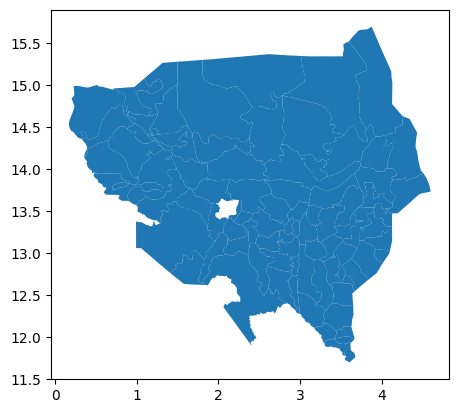

In [292]:
codab.plot()

In [268]:
impact.columns

Index(['idEvent', 'Régions', 'Départments', 'Communes', 'Type Commune',
       'Localités', 'Code Renaloc', 'Type localité', 'Source localité',
       'Ville', 'Date début event', 'Date fin event', 'Date mise à jour',
       'Note', 'Pluie (mm)', 'Précision de date', 'Type cause',
       'Nombre de localités affectées', 'Pertes d'elevage (UBT)',
       'Pertes de cultures (ha)', 'Personnes affectées', 'Maisons détruites',
       'Pertes en vies humaines', 'Blessés', 'Pertes de vivres (tonnes)',
       'Cases détruites', 'Greniers détruits', 'Puits détruits',
       'Boutiques détruites', 'Mosquées détruites', 'Barrages détruits',
       'Digues détruites', 'Clases d'école détruites', 'Magasins détruits',
       'Moulins à grain détruits', 'Postes radio détruits',
       'Centres de santé détruits', 'date', 'match_adm3', 'rowcacode3'],
      dtype='object')

<Axes: xlabel='date'>

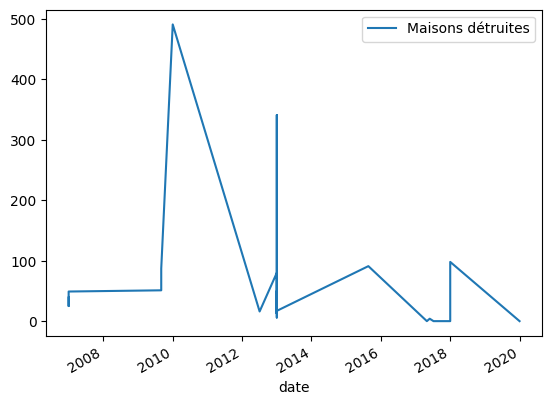

In [269]:
impact[impact[utils.ID_COL] == F4].plot(x="date", y="Maisons détruites")

In [352]:
df_plot = codab.merge(
    impact.groupby(utils.ID_COL).sum(numeric_only=True).reset_index(),
    on=utils.ID_COL,
)
display(df_plot.geometry)
for col in ["Personnes affectées", "Maisons détruites"]:
    fig = px.choropleth(
        df_plot, geojson=df_plot.geometry, locations=df_plot.index, color=col
    )
    fig.update_geos(fitbounds="locations", visible=False)
    fig.update_layout(
        width=800,
        height=500,
        #         margin={"r": 0, "t": 0, "l": 0, "b": 0},
    )
    fig.show()

0     POLYGON ((0.96368 14.53833, 0.95209 14.52112, ...
1     POLYGON ((0.52234 14.99325, 0.53778 14.98095, ...
2     POLYGON ((0.65226 14.33898, 0.65228 14.33911, ...
3     POLYGON ((0.91968 13.96729, 0.91888 13.94208, ...
4     POLYGON ((0.93311 14.66968, 0.96332 14.65649, ...
                            ...                        
83    POLYGON ((3.79828 13.84351, 3.83710 13.83569, ...
84    POLYGON ((4.54907 13.89471, 4.57532 13.83289, ...
85    POLYGON ((4.12850 13.32176, 4.10651 13.31653, ...
86    POLYGON ((4.02551 14.27930, 4.03131 14.26147, ...
87    POLYGON ((4.43829 14.42950, 4.43231 14.41370, ...
Name: geometry, Length: 88, dtype: geometry

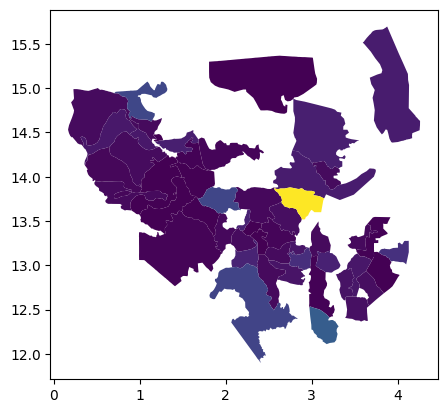

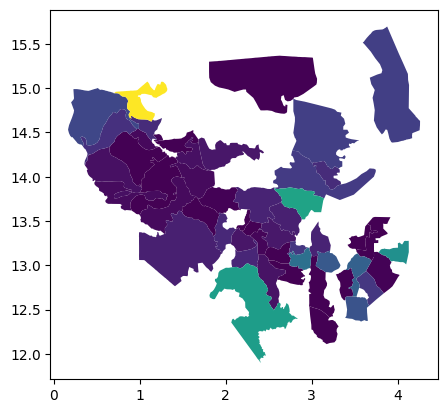

In [270]:
years = [2020]
for year in years:
    dff = impact[impact.date.dt.year == year]
    dff = dff.groupby(utils.ID_COL).sum(numeric_only=True)
    df_plot = codab.merge(dff, on=utils.ID_COL)

    col = "Personnes affectées"
    fig = df_plot.sort_values(col).iloc[:].plot(column=col)

    col = "Maisons détruites"
    fig = df_plot.sort_values(col).iloc[:].plot(column=col)

In [271]:
# check for correlation between floodscan and impact data

floodscan = utils.load_processed_floodscan()

In [280]:
# fs_f = floodscan[floodscan[utils.ID_COL].isin(ADM3S)]
fs_f = floodscan.copy()
fs_f = fs_f.groupby([utils.ID_COL, "seasonyear"]).mean(numeric_only=True)
# impact_f = impact[impact[utils.ID_COL].isin(ADM3S)]
impact_f = impact.copy()
impact_f["seasonyear"] = impact_f.date.dt.year
impact_f = impact_f.groupby([utils.ID_COL, "seasonyear"]).sum(
    numeric_only=True
)

fs_im = fs_f.merge(impact_f, on=[utils.ID_COL, "seasonyear"]).reset_index()
fs_im = fs_im.merge(codab[[utils.ID_COL, "adm_03"]], on=utils.ID_COL)

,OBJECTID,ID,NOM_COM,adm_01,adm_02,adm_03,rowcacode1,rowcacode2,rowcacode3,Shape_Leng,Shape_Area,ISO3,ISO2,geometry,match_adm3,maison,personne
22,24,0,GAYA,Dosso,Gaya,Gaya,NER003,NER003006,NER003006003,0.861500,0.023504,NER,NE,"POLYGON ((3.28528 11.94427, 3.29712 11.94269, ...",gaya,0.625567,0.388589
24,26,0,TOUNOUGA,Dosso,Gaya,Tounouga,NER003,NER003006,NER003006005,0.687775,0.018938,NER,NE,"POLYGON ((3.55750 11.92188, 3.55751 11.92188, ...",tounouga,0.738908,0.437012
26,28,0,TANDA,Dosso,Gaya,Tanda,NER003,NER003006,NER003006004,0.822654,0.035319,NER,NE,"POLYGON ((3.17327 12.10895, 3.21130 12.12207, ...",tanda,0.796102,0.697745


,Maisons détruites,mean_cell
Maisons détruites,1.000000,0.625567
mean_cell,0.625567,1.000000


,Maisons détruites,mean_cell
Maisons détruites,1.000000,0.738908
mean_cell,0.738908,1.000000


,Maisons détruites,mean_cell
Maisons détruites,1.000000,0.796102
mean_cell,0.796102,1.000000


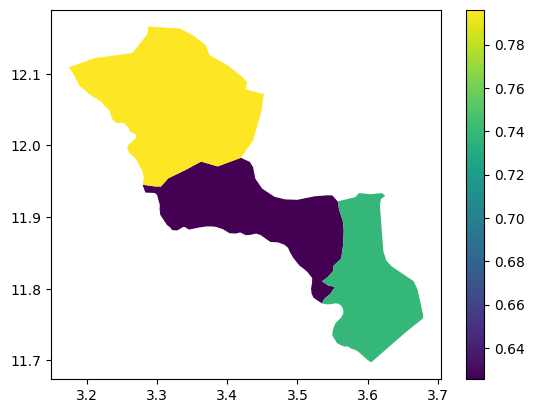

In [321]:
correlations = pd.DataFrame()
for adm3 in fs_im[utils.ID_COL].unique():
    dff = fs_im[fs_im[utils.ID_COL] == adm3]
    maison, personne = dff.corr(numeric_only=True).loc[
        "mean_cell", ["Maisons détruites", "Personnes affectées"]
    ]
    df_add = pd.DataFrame(
        {utils.ID_COL: adm3, "maison": maison, "personne": personne}, index=[0]
    )
    correlations = pd.concat([correlations, df_add], ignore_index=True)

correlations.dropna().sort_values("maison")

df_plot = codab.merge(correlations, on=utils.ID_COL)
col = "maison"
# df_plot = df_plot[df_plot[col] > 0]
df_plot = df_plot[df_plot[utils.ID_COL].isin(ADM3S)]
display(df_plot)
fig = df_plot.plot(column=col, legend=True)

for adm3 in ADM3S:
    df_plot = fs_im[fs_im[utils.ID_COL] == adm3]
    name = df_plot["adm_03"].iloc[0]
    display(
        df_plot[["Maisons détruites", "mean_cell"]].corr(numeric_only=True)
    )
    fig = px.scatter(
        df_plot,
        y="Maisons détruites",
        x="mean_cell",
        hover_data="seasonyear",
        trendline="ols",
    )
    fig.update_traces(marker_color=GREEN, marker_size=10)
    fig.update_layout(
        template="simple_white",
        title=name,
        height=500,
        width=500,
    )
    fig.update_xaxes(title="Étendue d'inondation", rangemode="tozero")
    fig.update_yaxes(rangemode="tozero")
    fig.show()